# REDUCTIONS IN NP COMPLETE PROBLEMS: 3-COL to 3-SAT

A Graph $G$ is 3-colorable if you can color all of its vertices using no more than 3 colors such that no two adjacent vertices that are connected by an edge are the same color.

Given a Graph $G$ with Nodes $V$ and Edges $E$ and access to a solver class for 3-SAT, use a reduction from 3-COL to 3-SAT to determine whether $G$ is 3-colorable. If $G$ is 3-colorable, output a valid assignment of colors for the vertices of $G$. Otherwise state that $G$ is not colorable. 

Note that the Graph and SAT classes have already been fully implemented. Your task is to implement the reduction function COL_to_SAT. More details about skeleton code and your task can be found in the respective docstrings.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random

### GRAPH CLASS AND EXAMPLES

In [2]:
class Graph(object):
    
    def __init__(self, V = [], E = []):
        """ 
        Initializes a graph object G with vertices from set V and edges from list of tuples E

        Vertices should be represented as strings of alphanumeric characters only
        
        Sample usage:
        >>> small_graph = Graph(['A', 'B', 'C'], [('A', 'B'), ('A', 'C'), ('B', 'C')])
        """
        assert all([v.isalnum() for v in V])
        self.G = nx.Graph()
        self.G.add_nodes_from(V)
        self.G.add_edges_from(E)

    def vertices(self):
        """ 
        Returns a set containing all vertices of G
        
        Sample usage:
        >>> small_graph.vertices()
        {'A', 'B', 'C'}
        """
        return set(self.G.nodes())
            
    def edges(self, vertex = None):
        """ 
        Returns a list of tuples containing all edges that are incident to vertex of G
        
        If vertex is set to None the function simply returns all the edges of G
        
        Sample usage:
        >>> small_graph.edges()
        [('A', 'B'), ('A', 'C'), ('B', 'C')]
        >>> small_graph.edges('A')
        [('A', 'B'), ('A', 'C')]
        """
        return list(self.G.edges(vertex))
     
    def add_vertices(self, vertices):
        """ 
        Adds every new vertex in vertices to G
        
        Vertices should be represented as strings of alphanumeric characters only
        
        Sample usage:
        >>> small_graph.vertices()
        {'A', 'B', 'C'}
        >>> small_graph.add_vertex({'D'})
        >>> small_graph.vertices()
        {'A', 'B', 'C', 'D'}
        >>> small_graph.add_vertex({'E', 'F'})
        >>> small_graph.vertices()
        {'A', 'B', 'C', 'D', 'E', 'F'}
        """
        assert all([v.isalnum() for v in vertices])
        self.G.add_nodes_from(vertices)
        
    def add_edges(self, edges):
        """
        Adds an edge for every tuple in the edges list to G
        
        Sample usage:
        >>> small_graph.edges()
        [('A', 'B'), ('A', 'C'), ('B', 'C')]
        >>> small_graph.add_edges([('A', 'D')])
        >>> small_graph.edges()
        [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C')]
        >>> small_graph.add_edges([('B', 'D'), ('C', 'D')])
        >>> small_graph.edges()
        [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
        """
        self.G.add_edges_from(edges)        

    def visualize(self):
        """
        Displays a visual representation of the Graph
        
        Sample usage:
        >>> small_graph.visualize()
        < cool image appears here >
        """
        nx.draw_networkx(self.G)
        plt.show()

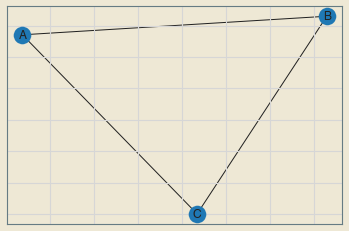

In [3]:
G_small1 = Graph(["A", "B", "C"], [("A", "B"), ("A", "C"), ("B", "C")])
G_small1.visualize()

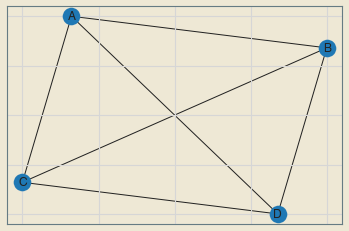

In [4]:
G_small2 = Graph(["A", "B", "C"], [("A", "B"), ("A", "C"), ("B", "C")])
G_small2.add_vertices({'D'})
G_small2.add_edges([("A", "D"), ("B", "D"), ("C", "D")])
G_small2.visualize()

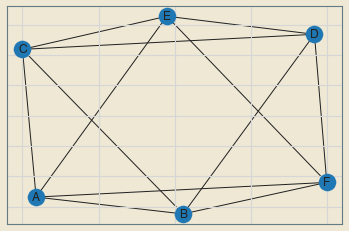

In [5]:
G_medium1 = Graph(["A", "B", "C", "D", "E", "F"], 
                       [("A", "B"), ("A", "C"), ("A", "E"), ("A", "F"), 
                        ("B", "C"), ("B", "D"), ("B", "F"),
                        ("C", "D"), ("C", "E"),
                        ("D", "E"), ("D", "F"),
                        ("E", "F")])
G_medium1.visualize()

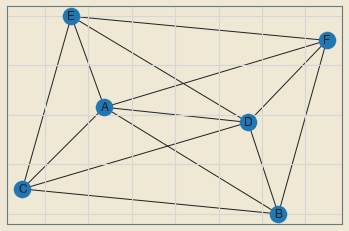

In [6]:
G_medium2 = Graph(["A", "B", "C", "D", "E", "F"], 
                       [("A", "B"), ("A", "C"), ("A", "D"), ("A", "E"), ("A", "F"), 
                        ("B", "C"), ("B", "D"), ("B", "F"),
                        ("C", "D"), ("C", "E"),
                        ("D", "E"), ("D", "F"),
                        ("E", "F")])
G_medium2.visualize()

### SAT CLASS AND EXAMPLES:

In [7]:
class SAT(object):
    
    def __init__(self):
        """ 
        Initializes a SAT instance to solve 3SAT
        
        Sample usage:
        >>> sat = SAT()
        """
        self.cnf = []
        self.make_false()
        
    def make_false(self):
        """
        Adds trivial clauses to SAT instance to force a 'false' variable 
        with value False which can be used as a trivial 3rd variable in 
        clauses with only 2 real variables so that the 3 variables per 
        clause structure of 3SAT is maintained
        YOU SHOULD NOT CALL THIS FUNCTION DIRECTLY
        """
        self.add_clauses([('ignore1', 'ignore2', '~false'), 
                          ('ignore1', '~ignore2', '~false'), 
                          ('~ignore1', 'ignore2', '~false'), 
                          ('~ignore1', '~ignore2', '~false')])

    def add_clause(self, variable_1, variable_2, variable_3 = 'false'):
        """ 
        Adds a 3SAT clause with variable_1, variable_2, and variable_3 to the 
        cnf of the SAT object where each variable is represented as a string
       
        If only variable_1 and variable_2 are passed in, a trivial false variable
        is used as the third variable so that the 3 variable structure of a 3SAT 
        clause is maintained
        
        Variables can be named anything except 'false', 'ignore1', and 'ignore2' 
        as these are provisional variables maintained internally by the SAT instance
        
        Calling sat.add_clause('x', 'y', 'z') is equivalent to adding the clause
        (x or y or z) to the SAT cnf formula
        
        To add the complement of any variable to a clause, simply prefix it with 
        a '~' and then the variable name. ex: sat.add_clause('~x', 'y', '~z') is 
        equivalent to adding the clause (not x or y or not z) to the SAT cnf formula
        
        
        You should not use the following three variable names in your SAT clauses:
        'false', 'ignore1', 'ignore2' because these are provisional variables 
        defined and maintained by the
        
        Sample usage:
        >>> sat = SAT()
        >>> sat.add_clause('a', 'b', 'c')   # cnf = (a or b or c)
        >>> sat.add_clause('~a', '~d', 'e') # cnf = (a or b or c) and (not a or not d or e)
        >>> sat.add_clause('b', 'd')        # cnf = (a or b or c) and (not a or not d or e) and (b or d or false)
        """
        clause = set()
        for term in [variable_1, variable_2, variable_3]:
            if term[0] == '~':
                clause.add((term[1:], False))
            else:
                clause.add((term, True))
        return self.cnf.append(clause)
        
    def add_clauses(self, expressions):
        """
        Adds multiple clauses to the 3SAT cnf formula by adding a clause for 
        every tuple expression in the list expressions
        
        Sample usage:
        >>> sat = SAT()
        >>> sat.add_clauses([('a', 'b', 'c'), ('~a', '~d', 'e'), ('b', 'd')]) 
        # cnf = (a or b or c) and (not a or not d or e) and (b or d or false)
        """
        for expression in expressions:
            assert len(expression) == 2 or len(expression) == 3
            if len(expression) == 2:
                self.add_clause(expression[0], expression[1])
            else:
                self.add_clause(expression[0], expression[1], expression[2])
                
    def solve(self, naive = False):
        """
        Solves the SAT instance using a back-tracking based DPLL algorithm and 
        returns whether the SAT instance is satisfiable along with a dictionary 
        with valid assignments for variables of the SAT instance if it is satisfiable
        
        Sample usage:
        >>> sat1 = SAT()
        >>> sat1.add_clause('a', 'b')   # cnf = (a or b or false)
        >>> sat1.add_clause('~a', '~b') # cnf = (a or b or false) and (not a or not b)
        >>> satisfiable, assignments = sat1.solve()
        >>> satisfiable
        True
        >>> assignments
        {'b': True, 'a': False}
        >>> sat2 = SAT()
        >>> sat2.add_clauses([('a', 'b'), ('a', '~b'), ('~a', 'b'), ('~a', '~b')])
        # cnf is now (a or b or false) and (a or not b or false) and (not a or b or false) and (not a or not b or false)
        >>> satisfiable, assignments = sat2.solve()
        >>> satisfiable
        False
        >>> assignments 
        None
        """
        if naive:
            satisfiable, assignments = self.brute_force_3SAT_Solver(self.cnf)
        else:
            satisfiable, assignments = self.dpll_3SAT_Solver(self.cnf)
        if satisfiable:
            assignments.pop('false', None)
            assignments.pop('ignore1', None)
            assignments.pop('ignore2', None)
        return satisfiable, assignments
    
    def dpll_3SAT_Solver(self, cnf, assignments={}):
        """
        Internally used DPLL algorithm used to solve the 3SAT instance
        YOU SHOULD NOT CALL THIS FUNCTION DIRECTLY
        Instead use: sat.solve()
        
        This function is adapted from https://gist.github.com/davefernig/e670bda722d558817f2ba0e90ebce66f
        """
        def select_literal(cnf):
            for c in cnf:
                for literal in c:
                    return literal[0]
        if len(cnf) == 0:
            return True, assignments
        if any([len(c)==0 for c in cnf]):
            return False, None
        l = select_literal(cnf)
        new_cnf = [c for c in cnf if (l, True) not in c]
        new_cnf = [c.difference({(l, False)}) for c in new_cnf]
        sat, vals = self.dpll_3SAT_Solver(new_cnf, {**assignments, **{l: True}})
        if sat:
            return sat, vals
        new_cnf = [c for c in cnf if (l, False) not in c]
        new_cnf = [c.difference({(l, True)}) for c in new_cnf]
        sat, vals = self.dpll_3SAT_Solver(new_cnf, {**assignments, **{l: False}})
        if sat:
            return sat, vals
        return False, None
    
    def brute_force_3SAT_Solver(self, cnf):
        """
        Provisional brute force algorithm used to solve the 3SAT instance
        YOU SHOULD NOT CALL THIS FUNCTION DIRECTLY
        Instead use sat.solve(naive = False)

        This function is adapted from https://gist.github.com/davefernig/e670bda722d558817f2ba0e90ebce66f
        """
        literals = set()
        for conj in cnf:
            for disj in conj:
                literals.add(disj[0])
        literals = list(literals)
        n = len(literals)
        for seq in itertools.product([True,False], repeat=n):
            a = set(zip(literals, seq))
            if all([bool(disj.intersection(a)) for disj in cnf]):
                assignments = {item[0]: item[1] for item in a}
                return True, assignments
        return False, None

In [8]:
# Feel free to play around with a few different clauses and  
# SAT instances here before proceeding with the reduction

sat = SAT()

sat.add_clause('a', 'b')   
sat.add_clause('~a', '~b') 
# cnf = (a or b or false) and (not a or not b or false)

# Add some more clauses to play around with here

sat.solve()

(True, {'b': True, 'a': False})

### YOUR SOLVER HERE:

In [16]:
def COL_to_SAT(G, naive = False):
    """
    Given a graph G and access to the SAT class, use a reduction from 
    3COL to 3SAT to determine whether G is 3 colorable or not. If it is 
    satisfiable, output a valid assignment of colors for every vertex
    in the graph in a dictionary. You can choose any 3 distinct colors
    to mark the vertices. It doesn't matter which vertex is colored which 
    color as long as neighboring vertices are marked with differently.
    
    If naive is set to true, use the naive solver for the SAT instance
    
    Expected behavior:
    >>> G_small1 = Graph(['A', 'B', 'C'], [('A', 'B'), ('A', 'C'), ('B', 'C')])
    >>> satisfiable, assignments = COL_to_SAT(G_small1)
    >>> satisfiable
    True
    >>> assignments
    {'A': '_red', 'B': '_green', 'C': '_blue'}
    >>> G_small2 = Graph(['A', 'B', 'C', 'D'], [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')])
    >>> satisfiable, assignments = COL_to_SAT(G_small2)
    >>> satisfiable
    False
    >>> assignments
    None    
    """
    color1 = "_red"
    color2 = "_green"
    color3 = "_blue"
    sat = SAT()
    
    vertices = G.vertices()
    edges = G.edges()
    for v in vertices:
        sat.add_clause(v + color1, v + color2, v + color3)
    for (u, v) in edges:
        sat.add_clause('~' + u + color1, '~' + v + color1)
        sat.add_clause('~' + u + color2, '~' + v + color2)
        sat.add_clause('~' + u + color3, '~' + v + color3)
    success, sat_asst = sat.solve()
    if success:
        color_asst = {}
        for v in vertices:
            for c in [color1, color2, color3]:
                if sat_asst[v + c]:
                    color_asst[v] = c
                    break
        return True, color_asst
    else:
        return False, None
        
        
    

### TESTING:

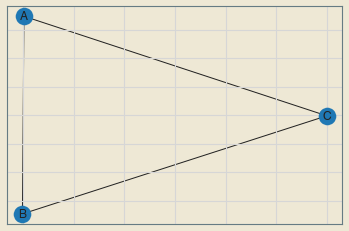

CPU times: user 164 ms, sys: 8.58 ms, total: 173 ms
Wall time: 186 ms


(True, {'C': '_red', 'B': '_green', 'A': '_blue'})

In [17]:
%%time
G = G_small1
G.visualize()
COL_to_SAT(G)

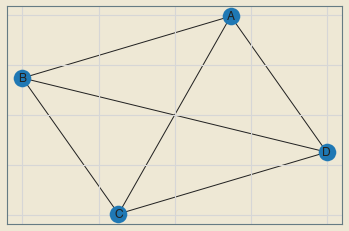

CPU times: user 170 ms, sys: 7.86 ms, total: 178 ms
Wall time: 198 ms


(False, None)

In [18]:
%%time
G = G_small2
G.visualize()
COL_to_SAT(G)

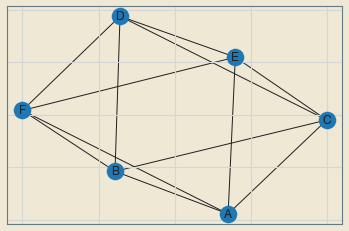

CPU times: user 163 ms, sys: 8.15 ms, total: 171 ms
Wall time: 178 ms


(True,
 {'C': '_red',
  'F': '_red',
  'D': '_green',
  'B': '_blue',
  'E': '_blue',
  'A': '_green'})

In [19]:
%%time
G = G_medium1
G.visualize()
COL_to_SAT(G)

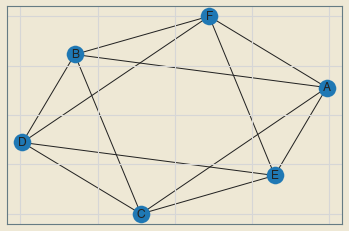

CPU times: user 180 ms, sys: 9.29 ms, total: 189 ms
Wall time: 201 ms


(True,
 {'C': '_red',
  'F': '_red',
  'D': '_green',
  'B': '_blue',
  'E': '_blue',
  'A': '_green'})

In [20]:
%%time
G = G_medium1
G.visualize()
COL_to_SAT(G, naive = True)

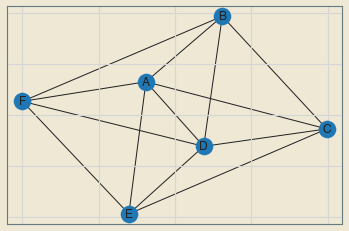

CPU times: user 184 ms, sys: 9.29 ms, total: 193 ms
Wall time: 212 ms


(False, None)

In [21]:
%%time
G = G_medium2
G.visualize()
COL_to_SAT(G)

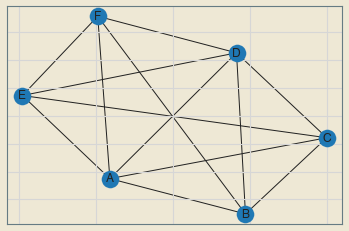

CPU times: user 176 ms, sys: 6.85 ms, total: 183 ms
Wall time: 199 ms


(False, None)

In [22]:
%%time
G = G_medium2
G.visualize()
COL_to_SAT(G, naive = True) 

## TAKEAWAY:

You might wonder why we would want to reduce one NP-Complete problem to another NP-Complete problem 
since they would both end up taking exponential time to solve in the worst case anyways. 

However, some NP-Complete problems such as 3SAT are very well studied. As a result, researchers develop 
problem-specific strategies over time to find solutions for these problems relatively faster. While the 
worst case time complexity is still exponential, you probably noticed that in general the brute force 
solver for 3SAT (which is called when naive is set to True) takes much longer to reach a solution compared
to the DPLL solver for 3SAT which is used by our SAT solver by default. Reductions between NP-Complete
problems try to take advantage of exactly this!

If we wanted to solve a 3COL problem (which is relatively less well studied) more quickly on average, we would 
have to spend a lot of time researching the problem to come up with appropriate strategies that would make our
search for valid color assignments quicker. However, using a reduction from 3COL to 3SAT, we can directly take 
advantage of the many sophisticated solvers that already exist for 3SAT and use those to our advantage to get
a relatively quicker solver for 3COL.

Kinda cool, right?